In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

## Overview
### This script performs lane detection in an image using Hough Transform, The steps involved are:
#### 1.⁠ ⁠*Load Image*: Read the image from the file.
#### 2.⁠ ⁠*Preprocess Image*: Convert it to grayscale, apply blurring, and detect edges.
#### 3.⁠ ⁠*Region of Interest (ROI)*: Select only the road area to reduce noise.
#### 4.⁠ ⁠*Hough Transform*: Detect lane lines by accumulating votes in Hough space.
#### 5.⁠ ⁠*Overlay Lines*: Superimpose detected lanes on the original image.
#### 6.⁠ ⁠*Display Results*: Show the outputs at different stages.

In [113]:
#Load image
image = cv2.imread("road2.jpeg")

### Preprocess the image by converting to grayscale, applying a median blur, and detecting edges
#### 1. Convert the image to grayscale to simplify processing
#### 2. Apply a median blur to reduce noise while preserving edges
#### 3. Use the Canny edge detector to extract edges from the image

In [114]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, 5)
    edges = cv2.Canny(blurred, 30, 120)
    return edges

#### Masks the image to focus only on region of interest (the lane lines)
#### it creates a mask in the shape of a polygon covering the road area.

In [115]:
def ROI(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)
    polygon = np.array([[(100, height), (width//2 - 100, height//2 + 50), 
                         (width//2 + 100, height//2 + 50), (width-100, height)]], dtype=np.int32)
    cv2.fillPoly(mask, polygon, 255)
    masked_edges = cv2.bitwise_and(edges, mask)
    return masked_edges

In [116]:
def non_maximum_suppression(accumulator, threshold):
    suppressed = np.zeros_like(accumulator)
    for i in range(1, accumulator.shape[0] - 1):
        for j in range(1, accumulator.shape[1] - 1):
            local_patch = accumulator[i-1:i+2, j-1:j+2]
            if accumulator[i, j] == np.max(local_patch) and accumulator[i, j] > threshold:
                suppressed[i, j] = accumulator[i, j]
    return suppressed

#### detects lines by accumulating votes in the Hough space in the edge-detected image.

In [117]:
def hough_transform(edges, image):
    height, width = edges.shape
    max_dist = int(math.sqrt(height**2 + width**2))  #Maximum possible rho value
    theta_range = np.deg2rad(np.arange(-90, 90))  # -90 to 90 degrees
    accumulator = np.zeros((2 * max_dist + 1, len(theta_range)), dtype=np.int32) 
    edge_points = np.argwhere(edges)  # Get all nonzero edge pixels
    print(edge_points)
    print(len(edge_points))

    #Accumulate votes in Hough space
    for y, x in edge_points:
        for t_idx, theta in enumerate(theta_range):
            rho = int(x * np.cos(theta) + y * np.sin(theta)) + max_dist  # Ensure non-negative index
            if 0 <= rho < accumulator.shape[0]: #Checking bounds
                accumulator[rho, t_idx] += 1

    accumulator = non_maximum_suppression(accumulator, threshold=100)
    lines = [(r - max_dist, theta_range[t]) for r, t in np.argwhere(accumulator > 0)]

    #draw the detected lines on a blank image
    line_image = np.zeros_like(image)

    #convert it to cartesian
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        #Define lane region limits
        y1 = height #Bottom of image
        y2 = int(height * 0.6) #Top limit for lane line

        #calculate corresponding x values
        if a != 0:
            x1 = int((rho - y1 * b) / a)
            x2 = int((rho - y2 * b) / a)
        else:
            x1, x2 = x0, x0 

        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
    print(accumulator)   
    return line_image

#### Overlay detected lane lines into the original image

In [118]:
def overlay_lines(image, lines):
    return cv2.addWeighted(image, 0.8, lines, 1, 0)

In [119]:
#Process image
edges = preprocess_image(image)
roi_edges = ROI(edges)
line_image = hough_transform(roi_edges, image)
final_image = overlay_lines(image, line_image)

[[320 398]
 [320 418]
 [320 434]
 ...
 [539 160]
 [539 180]
 [539 852]]
2079
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


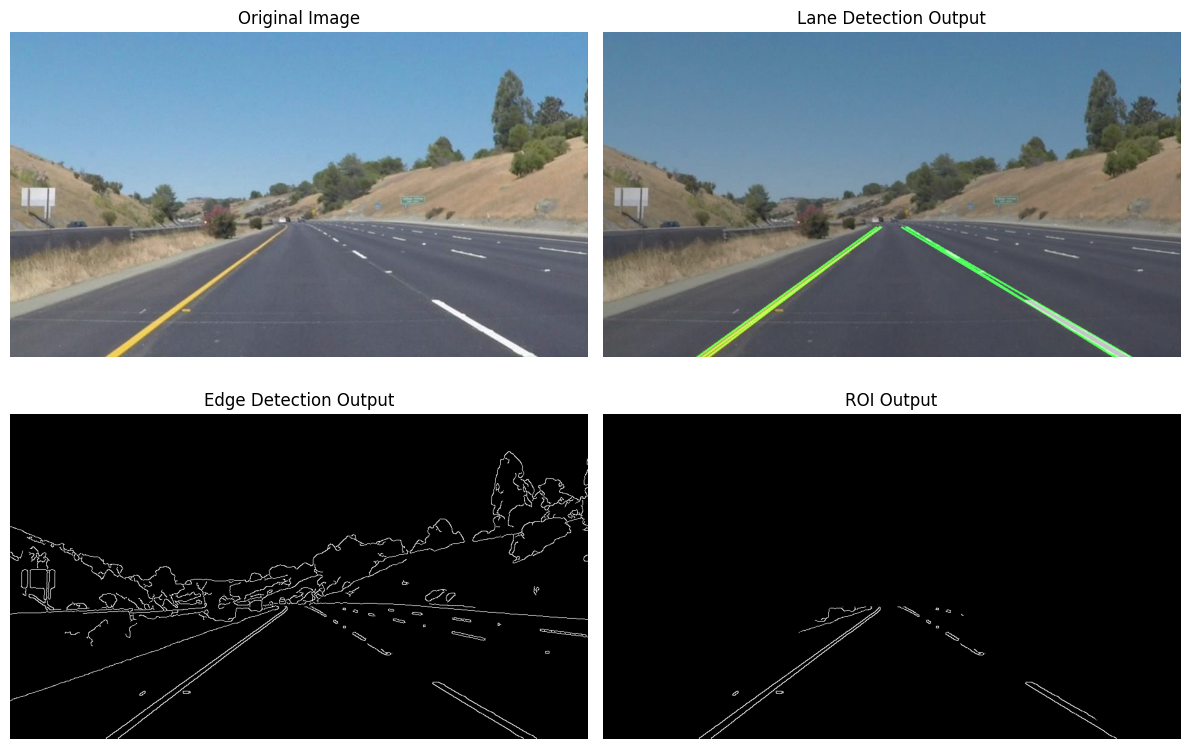

In [120]:
#Display
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  
axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  #Convert BGR to RGB for correct display
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Lane Detection Output")
axes[0, 1].axis("off")

axes[1, 0].imshow(edges, cmap="gray")
axes[1, 0].set_title("Edge Detection Output")
axes[1, 0].axis("off")

axes[1, 1].imshow(roi_edges, cmap="gray")
axes[1, 1].set_title("ROI Output")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

In [121]:
cv2.imwrite("edge_output.png", edges)
cv2.imwrite("roi_output.png", roi_edges)
cv2.imwrite("lane_detection.png", final_image)

True